# Overview

Convolutional Neural Networks (CNNs) have dominated the field of computer vision for years. However, recent advancements in transformer architectures, originated from attention is all you need paper, have shown great promise in image classification tasks despite known for their success in Natural Language Processing (NLP). Vision Transformer (ViT) leverages the power of transformers for computer vision tasks.

This notebook delves into the world of ViT by implementing one from scratch using PyTorch. Here, we build a ViT model for image classification and train it on a subset of the RSNA breast cancer detection dataset, aiming to showcase its capabilities in complex real-world applications.

# 1. About the Architecture

Transformers are a game-changing architecture in the world of neural networks. They excel at modeling data where understanding long-range relationships is crucial. This overview dives into the key components that make transformers so effective:

- **Multi-headed Attention:** This mechanism allows the network to focus on specific, relevant parts of the input data, even if they're far apart in the sequence.
- **Residual Connections:** These connections help the network learn from previous layers, enabling better training and deeper architectures.
- **Layer Normalization:** This technique ensures stable training by normalizing the activations at each layer of the transformer.
- **Feedforward Connections:** These non-linear layers add complexity and allow the network to learn more intricate relationships within the data.
- **Positional Embeddings:** When dealing with data that lacks inherent order (like text), these embeddings provide positional information, crucial for the transformer to understand the sequence.

By combining these elements, transformers have revolutionized various fields, including natural language processing, computer vision, and beyond.

<p align="center">
    <img src="https://production-media.paperswithcode.com/method_collections/trans.jpeg" width="500" alt="Transformer Architecture"/>
    <br>
    Figure: Architecture of the original Transformer .
</p>

### **Making Transformers See: Patching Images into Words**

Originally used for language, transformers can now be applied to images. We do this by:

1. **Splitting the image:** We cut the image into tiny squares, like words in a sentence.
2. **Flattening and encoding:** We turn each square into a single unit and add information about its position in the image.
3. **Adding a start token:** We include a special token at the beginning, similar to a sentence starter.
4. **Feeding into the transformer:** We process this sequence of units using a transformer encoder, which analyzes relationships between them.
5. **Classification:** We focus on the special token at the beginning and use it to predict the image content (e.g., what object it is).

PyTorch offers `torch.nn.MultiHeadAttention` for implementing attention mechanisms.

For a deeper dive, check out [original paper](https://paperswithcode.com/method/vision-transformer) on Vision Transformer.



<p align="center">
    <img src="https://raw.githubusercontent.com/google-research/vision_transformer/main/vit_figure.png" alt="Vision Transformer"/>
    <br>
    Figure: Architecture of the Vision Transformer model.
</p>

# 2. About the Dataset
The dataset was contributed by mammography screening programs in Australia and the U.S. It includes detailed labels, with radiologists’ evaluations and follow-up pathology results for suspected malignancies.

The dataset is stored in dicom formats. Converting dicom data to png/jpg just by rescaling it will harm the quality of the data. [This notebook](https://www.kaggle.com/code/raddar/convert-dicom-to-np-array-the-correct-way/notebook) is an awesome resource for anyone working with dicom files for X-Ray.

# 3. Implementation

### Setup

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rsna-breast-cancer-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F39272%2F4629629%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240402%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240402T154513Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dd61fea4018b21f40365509f4a4ae2e2d1e45abcbda5eed8368a56174da7c22da392107b5e9463468be29306db22fcad7a93a69da2481ac410a34adec83170a927b5ae9e79a0cdb71c11e32b78ab68eeeeb8742ba5bf9b14ec4d07fc20f1ec1e4fbfadef0f98c2a81f0c7d3567ab827615e6335274c39769a0c35d498e91c05645727bcfe4ff1692b10bd86457be6e2e5ca74ba184f56131e77b43c596112a0c8f260bcbb12789e6950b7ec296b9c667fb350288d226969332f7ca4950b2b400de35f7523cdda1bbdcf88bb7ee346681f190e4e9471af96e8d44fa8ebc26347a630b8260d93045b1ed432ccad70e5b56d74e6b9fddb687d2c403f6221a54a711a,rsna-breast-cancer-512-pngs:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2688675%2F4619805%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240402%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240402T154513Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3ef208eee823bbd936bdcf97c93a4e46aa1eae5aaa96afd0f7bca485f7e4b48ba20b564916f39bec124d91af793b428ca1c13a9300180012aa75ee036e306abac160d8bd6403a876b8debd63a7c03896b8a81f67b65ecf8443dc04d635e8496bf89eb748aa64b41ca2eb0911c86261079112733b989b7f10af9eb63649e8227a11a5a18ce7d8a13139f35645ee850101ccc25be55bf44c240fa6d60d6a311e2855929c3e3e20e9c1f331dfd355898b524e1bf0ec5741290cbed3a9559902a1270141da591a6b5197336a01c2a04bb07dbeab36fded8f6f1286e0742644ad8938cde07f5d5bd8bfa44ebdbbce915fcd252eab509b8873c5a396e3905fc43384ad,rsna-256px-croped:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2794616%2F4824226%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240402%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240402T154513Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da416525733f6d40316ed1287e88c09ee97a2e0a8568fd9a92b60a9ee326502e916013da10b0bb1d1ab9011421dcadf44e508ddd2f0a80f9a92d541d08bd01197bafbffab788651560f990ae4700e0a1976d87429c325bb3be695d21130a653a484c7fe9553d6bba2cdf0b284d9f4c7302c134e2a9bfe54a18047c78d74068ef798a5c873bf80bd7683a2431e8bc2ba76245fb616d496812ee43a3ad12a0f5fdd1b7f8843f18ed31441aeb5792b2f750541bc2e2acfa8add20d6cbb279bc5373a9b470418f68b1a1583c76e5a3591ac7d855974798afcf4e614de547036f3d5cff965bd729675536f75545b18136fe325998d9af4790f8bd544db48a8316e6779'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


### Imports

In [ ]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pydicom
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage
from ignite.contrib.handlers import ProgressBar
from sklearn.model_selection import train_test_split
from torchvision import models, transforms

## 3.1 Utility functions

In [ ]:
def read_xray(file_path, img_size=None):
    """
    Read the dicom data and get the image
    Args:
        file_path: The path of the dicom file
        img_size: Size of the output image
    """

    dicom = pydicom.read_file(file_path)
    img = dicom.pixel_array

    if dicom.PhotometricInterpretation == "MONOCHROME1":
        img = np.max(img) - img

    if img_size:
        img = cv2.resize(img, img_size)

    # Add channel dim at First
    img = img[np.newaxis]

    # Converting img to float32
    img = img / np.max(img)
    img = img.astype("float32")

    return img

In [ ]:
def patchify(batch, patch_size):
    """
    Patchify the batch of images

    Shape:
        batch: (b, h, w, c)
        output: (b, nh, nw, ph, pw, c)
    """
    b, c, h, w = batch.shape
    ph, pw = patch_size
    nh, nw = h // ph, w // pw

    batch_patches = torch.reshape(batch, (b, c, nh, ph, nw, pw))
    batch_patches = torch.permute(batch_patches, (0, 1, 2, 4, 3, 5))

    return batch_patches

We test our `patchify` function on a single image.

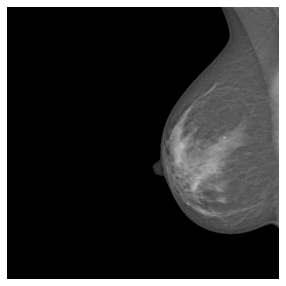

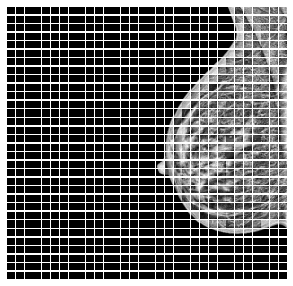

In [ ]:
FILE_PATH = '/kaggle/input/rsna-breast-cancer-detection/train_images/10048/1577142909.dcm'

img = read_xray(FILE_PATH, img_size=(512, 512))

batch = torch.tensor(img[None])
patch_size = (16, 16)
batch_patches = patchify(batch, patch_size)

patches = batch_patches[0]
c, nh, nw, ph, pw = patches.shape

plt.figure(figsize=(5, 5))
plt.imshow(img[0], cmap="gray")
plt.axis("off")

plt.figure(figsize=(5, 5))
for i in range(nh):
    for j in range(nw):
        plt.subplot(nh, nw, i * nw + j + 1)
        plt.imshow(patches[0, i, j], cmap="gray")
        plt.axis("off")

In [ ]:
def get_mlp(in_features, hidden_units, out_features):
    """
    Returns a MLP head
    """
    dims = [in_features] + hidden_units + [out_features]
    layers = []
    for dim1, dim2 in zip(dims[:-2], dims[1:-1]):
        layers.append(nn.Linear(dim1, dim2))
        layers.append(nn.ReLU())
    layers.append(nn.Linear(dims[-2], dims[-1]))
    return nn.Sequential(*layers)

## 3.2 Image to Sequence Block
This Block takes a batch of image as input and returns a batch of sequences. Later on we feed this sequences into the transformer encoder.

In [ ]:
class Img2Seq(nn.Module):
    """
    This layers takes a batch of images as input and
    returns a batch of sequences

    Shape:
        input: (b, h, w, c)
        output: (b, s, d)
    """
    def __init__(self, img_size, patch_size, n_channels, d_model):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size

        nh, nw = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        n_tokens = nh * nw

        token_dim = patch_size[0] * patch_size[1] * n_channels
        self.linear = nn.Linear(token_dim, d_model)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.pos_emb = nn.Parameter(torch.randn(n_tokens, d_model))

    def __call__(self, batch):
        batch = patchify(batch, self.patch_size)

        b, c, nh, nw, ph, pw = batch.shape

        # Flattening the patches
        batch = torch.permute(batch, [0, 2, 3, 4, 5, 1])
        batch = torch.reshape(batch, [b, nh * nw, ph * pw * c])

        batch = self.linear(batch)
        cls = self.cls_token.expand([b, -1, -1])
        emb = batch + self.pos_emb

        return torch.cat([cls, emb], axis=1)

## 3.3 Visual Transformer Module

This module can be divided into 3 parts:
* An image to sequence encoder
* Transformer encoder
* Multilayer perceptron head classification

We use `torch.nn.TransformerEncoder` and `torch.nn.TransformerEncoderLayer` to implement our transformer encoder.

In [ ]:
class ViT(nn.Module):
    def __init__(
        self,
        img_size,
        patch_size,
        n_channels,
        d_model,
        nhead,
        dim_feedforward,
        blocks,
        mlp_head_units,
        n_classes,
    ):
        super().__init__()
        """
        Args:
            img_size: Size of the image
            patch_size: Size of the patch
            n_channels: Number of image channels
            d_model: The number of features in the transformer encoder
            nhead: The number of heads in the multiheadattention models
            dim_feedforward: The dimension of the feedforward network model in the encoder
            blocks: The number of sub-encoder-layers in the encoder
            mlp_head_units: The hidden units of mlp_head
            n_classes: The number of output classes
        """
        self.img2seq = Img2Seq(img_size, patch_size, n_channels, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model, nhead, dim_feedforward, activation="gelu", batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, blocks
        )
        self.mlp = get_mlp(d_model, mlp_head_units, n_classes)

        self.output = nn.Sigmoid() if n_classes == 1 else nn.Softmax()

    def __call__(self, batch):

        batch = self.img2seq(batch)
        batch = self.transformer_encoder(batch)
        batch = batch[:, 0, :]
        batch = self.mlp(batch)
        output = self.output(batch)
        return output

# 4. Training

Here, we design a simple training to loop to train `ViT` model on a subset of dataset. We use an already cropped dataset.

## 4.1 Model Hyperparameters

In [ ]:
img_size = (512, 512)
patch_size = (16, 16)
n_channels = 1
d_model = 1024
nhead = 4
dim_feedforward = 2048
blocks = 8
mlp_head_units = [1024, 512]
n_classes = 1
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda')

## 4.2. Dataset and DataLoader

In [ ]:
class RSNADataset(Dataset):

    def __init__(self, df, img_path):
        self.df = df
        self.img_path = img_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        patient_id, image_id, cancer = self.df.iloc[idx][['patient_id', 'image_id', 'cancer']]
        file = os.path.join(self.img_path, f'{patient_id}_{image_id}.png')
        file = cv2.imread(file, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit = 15, tileGridSize=[8, 8])
        file = clahe.apply(file)
        file = file / file.max()
        X = torch.tensor(file[np.newaxis].astype('float32')).to(device)
        y = torch.tensor([cancer]).float().to(device)
        return X, y

In [ ]:
df = pd.read_csv('/kaggle/input/rsna-breast-cancer-detection/train.csv')
counts = df['cancer'].value_counts()
df['weights'] = df['cancer'].apply(lambda x: 1/counts[x])

train_df, val_df = train_test_split(df, test_size=0.25, stratify=df['cancer'])

In [ ]:
img_path = '/kaggle/input/rsna-breast-cancer-512-pngs'
train_samples = 1000
val_samples = 500

train_ds = RSNADataset(train_df, img_path)
val_ds = RSNADataset(val_df, img_path)

train_sampler = WeightedRandomSampler(train_df['weights'].values, train_samples)
train_loader = DataLoader(train_ds, batch_size=8, sampler=train_sampler)

val_sampler = WeightedRandomSampler(val_df['weights'].values, val_samples)
val_loader = DataLoader(val_ds, batch_size=32, sampler=val_sampler)

## 4.3 Training and Validation

In [ ]:
model = ViT(
    img_size=(512, 512),
    patch_size=(16, 16),
    n_channels=1,
    d_model=1024,
    nhead=4,
    dim_feedforward=1024,
    blocks=8,
    mlp_head_units=[512, 512],
    n_classes=1,
).to(device)

In [ ]:
print(model)

ViT(
  (img2seq): Img2Seq(
    (linear): Linear(in_features=256, out_features=1024, bias=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
   

In [ ]:
optimizer = Adam(model.parameters())
criterion = nn.BCELoss()
bce = Loss(criterion)

In [ ]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
val_metrics = {
    "bce": bce,
}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

In [ ]:
log_interval = 10
max_epochs = 10
best_loss = float('inf')

RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

pbar = ProgressBar()
pbar.attach(trainer, ['loss'])

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_loss
    evaluator.run(val_loader)
    loss = evaluator.state.metrics['bce']
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_model_vit.pt')
    print(f"Validation Results - Epoch: {trainer.state.epoch} Avg loss: {loss:.2f}")

output_state = trainer.run(train_loader, max_epochs=max_epochs)

[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 1 Avg loss: 0.70


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 2 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 3 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 4 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 5 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 6 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 7 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 8 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 9 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 10 Avg loss: 0.69


## 4.4 Comparison with ResNet50

In [ ]:
resnet = models.resnet50(pretrained=True)
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, 1)

resnet_transforms= transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.Lambda(lambda x: x.repeat([1, 3, 1, 1]))
])

class MyResNet(nn.Module):

    def __init__(self, transforms, model):
        super().__init__()
        self.transforms = transforms
        self.model = model
        self.output = nn.Sigmoid()

    def forward(self, batch):
        batch = self.transforms(batch)
        batch = self.model(batch)
        return self.output(batch)

In [ ]:
model = MyResNet(resnet_transforms, resnet).to(device)

optimizer = Adam(model.parameters())
criterion = nn.BCELoss()

trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
val_metrics = {
    "bce": Loss(criterion)
}
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)

In [ ]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

pbar = ProgressBar()
pbar.attach(trainer, ['loss'])

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    global best_loss
    evaluator.run(val_loader)
    loss = evaluator.state.metrics['bce']
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), 'best_model_resnet.pt')
    print(f"Validation Results - Epoch: {trainer.state.epoch} Avg loss: {loss:.2f}")

output_state = trainer.run(train_loader, max_epochs=max_epochs)

[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 1 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 2 Avg loss: 0.70


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 3 Avg loss: 0.70


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 4 Avg loss: 1.43


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 5 Avg loss: 0.70


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 6 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 7 Avg loss: 0.70


[1/125]   1%|           [00:00<?]

Validation Results - Epoch: 8 Avg loss: 0.69


[1/125]   1%|           [00:00<?]

# 5. Conclusion

The ViT model outperforms ReseNet50, one of the best CNN-based pretrained models. This shows great promise as it can be imporved further by fine-tuning and increasing the model complexity. ViTs are also great at scaling, so a bigger model almost always outperforms a smaller model.